In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import xarray as xr
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("/glade/u/home/lverhoef/gdl-storm-mode/notebooks"))
from imports.GDL_layers import *

2022-06-16 14:52:15.253618: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_validation_data.nc")

In [3]:
X_train = tf.expand_dims(tf.convert_to_tensor(train_ds['ellipse']), axis=-1)
Y_train = tf.convert_to_tensor(train_ds[['maj_len', 'min_len']].to_array().transpose())

2022-06-16 14:52:17.850922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 14:52:18.400097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [4]:
X_val = tf.expand_dims(tf.convert_to_tensor(validation_ds['ellipse']), axis=-1)
Y_val = tf.convert_to_tensor(validation_ds[['maj_len', 'min_len']].to_array().transpose())

In [5]:
model = models.Sequential()
model.add(RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(128, 128, 1)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(32, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(128, (3, 3)))
model.add(RotInvPool())
model.add(layers.Flatten())
model.add(layers.Dense(32))
model.add(layers.Dense(2))

In [6]:
model.compile(
    optimizer='adam',
    loss='mse',
)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 126, 126, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 63, 63, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 61, 61, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 28, 28, 4, 64)    1

In [8]:
history = model.fit(
    x=X_train, y=Y_train,
    epochs=10, validation_data=(X_val, Y_val),
    shuffle=True
)

Epoch 1/10


2022-06-16 14:52:32.514223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


313/313 [==============================] - 22s 53ms/step - loss: 27.9866 - val_loss: 14.8873
Epoch 2/10
313/313 [==============================] - 16s 51ms/step - loss: 10.0269 - val_loss: 3.3440
Epoch 3/10
313/313 [==============================] - 16s 52ms/step - loss: 3.0463 - val_loss: 1.8315
Epoch 4/10
313/313 [==============================] - 16s 51ms/step - loss: 2.1477 - val_loss: 1.2071
Epoch 5/10
313/313 [==============================] - 16s 51ms/step - loss: 1.2940 - val_loss: 1.1261
Epoch 6/10
313/313 [==============================] - 16s 51ms/step - loss: 1.1593 - val_loss: 0.8081
Epoch 7/10
313/313 [==============================] - 16s 51ms/step - loss: 0.9271 - val_loss: 0.8543
Epoch 8/10
313/313 [==============================] - 16s 51ms/step - loss: 0.7637 - val_loss: 0.8383
Epoch 9/10
313/313 [==============================] - 16s 51ms/step - loss: 0.7831 - val_loss: 0.5114
Epoch 10/10
313/313 [==============================] - 16s 51ms/step - loss: 0.6848 - val_

<xarray.Dataset>
Dimensions:  (p: 10)
Dimensions without coordinates: p
Data variables:
    maj_len  (p) float64 26.64 12.29 21.85 22.32 25.26 ... 21.0 36.23 38.3 28.21
    min_len  (p) float64 17.37 7.178 14.07 1.839 ... 12.29 16.74 17.86 8.65

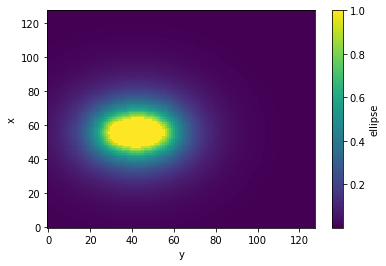

In [15]:
validation_ds['ellipse'][0, :, :].plot()
validation_ds[['maj_len', 'min_len']].sel(p=slice(0, 10))

In [16]:
model.predict(X_val[0:10, :, :, :])

1/1 [==============================] - 1s 501ms/step


array([[27.036198, 16.49149 ],
       [12.397746,  6.763775],
       [21.312408, 13.181325],
       [22.534462,  1.75183 ],
       [25.239275,  6.963908],
       [37.2989  , 19.496313],
       [20.897923, 11.505179],
       [36.327023, 16.287352],
       [37.467438, 17.377872],
       [28.947668,  8.199195]], dtype=float32)

In [17]:
CNN_model = models.Sequential()
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(32, activation='relu'))
CNN_model.add(layers.Dense(2))

In [18]:
CNN_model.compile(
    optimizer='adam',
    loss='mse',
)

In [19]:
CNN_history = CNN_model.fit(
    x=X_train, y=Y_train,
    epochs=10, validation_data=(X_val, Y_val),
    shuffle=True
)

Epoch 1/10
313/313 [==============================] - 3s 9ms/step - loss: 36.0634 - val_loss: 19.9361
Epoch 2/10
313/313 [==============================] - 3s 9ms/step - loss: 14.1005 - val_loss: 11.0086
Epoch 3/10
313/313 [==============================] - 3s 9ms/step - loss: 7.8713 - val_loss: 9.2190
Epoch 4/10
313/313 [==============================] - 3s 9ms/step - loss: 4.8151 - val_loss: 4.1609
Epoch 5/10
313/313 [==============================] - 3s 9ms/step - loss: 3.5595 - val_loss: 13.0186
Epoch 6/10
313/313 [==============================] - 3s 9ms/step - loss: 3.3854 - val_loss: 2.6079
Epoch 7/10
313/313 [==============================] - 3s 9ms/step - loss: 3.0854 - val_loss: 2.9758
Epoch 8/10
313/313 [==============================] - 3s 9ms/step - loss: 2.2974 - val_loss: 2.2806
Epoch 9/10
313/313 [==============================] - 3s 9ms/step - loss: 1.7329 - val_loss: 2.0926
Epoch 10/10
313/313 [==============================] - 3s 9ms/step - loss: 1.7276 - val_loss: 1

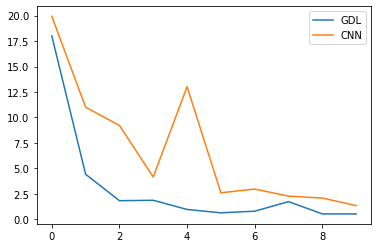

In [21]:
a = plt.plot(history.history['val_loss'], label='GDL')
b = plt.plot(CNN_history.history['val_loss'], label='CNN')
plt.legend()

In [22]:
test_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_test_data.nc")
X_test = tf.expand_dims(tf.convert_to_tensor(test_ds["ellipse"]), axis=-1)
Y_test = tf.convert_to_tensor(test_ds[['maj_len', 'min_len']].to_array().transpose())

In [23]:
model.evaluate(X_val, Y_val)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 19ms/step - loss: 0.7658 - mse: 0.7658


[0.7658436894416809, 0.7658436894416809]

In [24]:
CNN_model.evaluate(X_val, Y_val)
CNN_model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 38.1399


38.139923095703125

(array([10., 10., 13., 13., 12.,  8.,  9.,  4.,  6., 11.]),
 array([-0.13932943, -0.1111842 , -0.08303896, -0.05489373, -0.0267485 ,
         0.00139674,  0.02954197,  0.05768721,  0.08583244,  0.11397768,
         0.14212291], dtype=float32),
 <BarContainer object of 10 artists>)

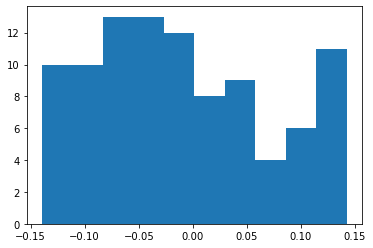

In [30]:
plt.hist(model.get_weights()[0][1].ravel())